In [1]:
import numpy as np
import geopandas
from shapely.geometry import Point, LineString
from manifm.utils import lonlat_from_cartesian

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

def plot_earth2d(ax, samples, color="#d73027", zoom=False, labels=["1000", "100", "10"]):
    assert len(samples) == len(labels)

    # Plot model samples
    geometry = [Point(lonlat_from_cartesian(x) / np.pi * 180) for x in samples]
    pts = geopandas.GeoDataFrame(geometry=geometry)
    pts[0:1].plot(ax=ax, color=color, marker="o", markersize=10, alpha=0.7)
    pts[1:2].plot(ax=ax, color=color, marker="^", markersize=10, alpha=0.7)
    pts[2:3].plot(ax=ax, color=color, marker="s", markersize=10, alpha=0.7)
    if zoom:
        # set max of x and y to be lim
        minx, miny, maxx, maxy = pts.total_bounds
        if ax.get_xlim()[1] - ax.get_xlim()[0] < 150:
            minx, maxx = min(minx, ax.get_xlim()[0]), max(maxx, ax.get_xlim()[1])
            miny, maxy = min(miny, ax.get_ylim()[0]), max(maxy, ax.get_ylim()[1])
        ax.set_xlim(minx-5, maxx+5)
        ax.set_ylim(miny-5, maxy+5)
    return ax


/tmp/ipykernel_3965314/2034297807.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


In [2]:

import torch
from manifm.eval_utils import load_model
from manifm.datasets import get_loaders, get_manifold
from manifm.model_pl import ManifoldAELitModule

device = "cuda"

def sample_with_different_num_steps(ckpt_path, num_steps_list=[1000, 100, 10]):
    torch.manual_seed(0)
    cfg, pl_model = load_model(ckpt_path)
    manifold, dim = get_manifold(cfg)
    pl_model.to(device)
    pl_model.train(mode=False)

    x0 = manifold.random_base(1024, dim).reshape(1024, dim)
    x1_dict = {}
    for num_steps in num_steps_list:
        # x1 = pl_model.sample(None, device, x0.to(device), num_steps=num_steps).cpu()
        x_t = pl_model.sample_all(None, device, x0.to(device), num_steps=num_steps).cpu()
        x1 = x_t[-1]
        x1_dict[num_steps] = x1
    return x1_dict

In [3]:
flow_ckpt_path = "/home/yjang43/workspace/riemannian-fm/outputs/multiruns/fire/fm/2024.11.19/231101/1/checkpoints/last.ckpt" # flow
reflow_ckpt_path = "/home/yjang43/workspace/riemannian-fm/outputs/runs/reflow_fire/fm/2024.11.21/223550/checkpoints/last.ckpt" # reflow

flow_x1_dict = sample_with_different_num_steps(flow_ckpt_path)
reflow_x1_dict = sample_with_different_num_steps(reflow_ckpt_path)

/home/yjang43/workspace/riemannian-fm/manifm/eval_utils.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpnt = torch.load(checkpoint, map_location="cpu")
/home/yjang4

In [4]:
def compute_truncation_error(x1_dict):
    gt_key = max(x1_dict.keys())
    truncation_error = {}
    for k in x1_dict:
        if k != gt_key:
            truncation_error[k] =(x1_dict[gt_key] - x1_dict[k]).norm()
    return truncation_error


print("Truncation Error for Flow (Ours)")
print(compute_truncation_error(flow_x1_dict))
print("Truncation Error for Reflow (Ours)")
print(compute_truncation_error(reflow_x1_dict))

Truncation Error for Flow (Ours)
{100: tensor(6.1526), 10: tensor(6.4179)}
Truncation Error for Reflow (Ours)
{100: tensor(1.5901), 10: tensor(1.8182)}


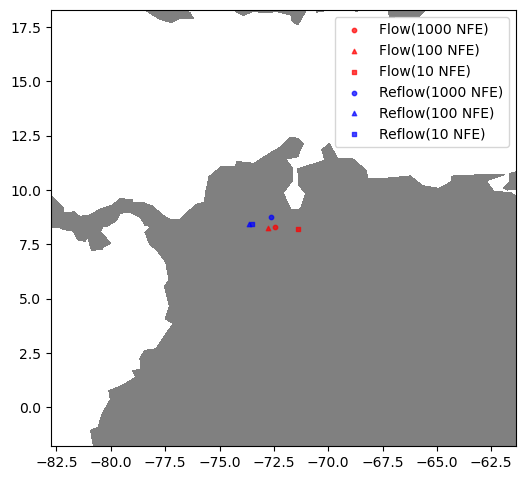

In [5]:

ax = world.plot(figsize=(6, 6), antialiased=False, color="grey")
idx = 0
flow_samples = []
for k in flow_x1_dict:
    flow_samples.append(flow_x1_dict[k][idx])
ax = plot_earth2d(ax, flow_samples, color="red", zoom=True)

reflow_samples = []
for k in reflow_x1_dict:
    reflow_samples.append(reflow_x1_dict[k][idx])
ax = plot_earth2d(ax, reflow_samples, color="blue", zoom=True)

ax.legend(["Flow(1000 NFE)", "Flow(100 NFE)", "Flow(10 NFE)", "Reflow(1000 NFE)", "Reflow(100 NFE)", "Reflow(10 NFE)"])